細胞の判別をする

下(左)の画像で濃い緑色に着色されている細胞を、下(右)の画像より検出する

元画像


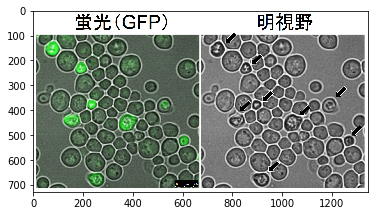

In [4]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

#元画像読み込み
#<http://tenure5.vbl.okayama-u.ac.jp/HM_blog/?p=2951>

img_org = Image.open("./img_org.png").convert("L")
width, height = img_org.size
imgdata_org = []
for y in range(height):
    for x in range(width):
        imgdata_org.append(img_org.getpixel((x,y)))

plt.imshow(np.asarray(Image.open('img_org.png')))
print("元画像")       

入力画像


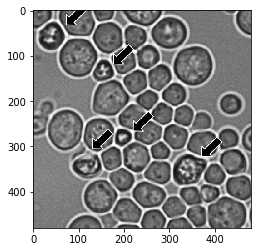

In [5]:
#実際に処理する画像の大きさにトリミング   480*480でやってみる
img_480 = Image.new('L', (480, 480))
for y in range(480):
    for x in range(480):
        img_480.putpixel((x,y),imgdata_org[(x+700)+width*(y+100)])
img_480.save("./img_480.png")


plt.imshow(np.asarray(Image.open('img_480.png').convert("L")), cmap='gray')
print("入力画像")

In [6]:
#入力画像読み込み
img_480 = Image.open("./img_480.png").convert("L")
width, height = img_480.size
imgdata = [0 for i in range(width*height)]
for y in range(height):
    for x in range(width):
        imgdata[x+480*y] = img_480.getpixel((x,y))
        
#画像を2値化する
TH = 140 #今回サンプルは1枚なので適当に決めている 160より140のがよさそう
for y in range(height):
    for x in range(width):
        if imgdata[x+y*width] > TH:
            imgdata[x+y*width] = 255
        else:
            imgdata[x+y*width] = 0 
            
#2値化した画像のそれぞれの領域にラベリングしてく
maxlabelnNo=0
table=[0 for i in range(1000)]
label = [0 for i in range(480*480)]
for y in range(height):
    for x in range(width):
        if (x>0 and y>0 and x<(width-2) and y<(height-2)):
            if imgdata[x+y*width] == 0:
                #周囲にラベルが貼られてない
                if (label[(x-1)+(y-1)*width] == 0 and label[x+(y-1)*width] == 0 and label[(x+1)+(y-1)*width] == 0 and label[(x-1)+y*width] == 0):
                    label[x+y*width] = maxlabelnNo
                    maxlabelnNo += 1
                #周囲にラベルが貼られている
                else:
                    tmp = 0
                    
                    if label[(x-1)+(y-1)*width] > 0:
                        tmp = label[(x-1)+(y-1)*width]
                    if label[x+(y-1)*width] > 0:
                        if tmp>0:
                            if label[x+(y-1)*width] > tmp:
                                table[label[x+(y-1)*width]] = tmp
                            else:
                                table[tmp] = label[x+(y-1)*width]
                                tmp = label[x+(y-1)*width]
                        else:
                            tmp = label[x+(y-1)*width]
                    if label[(x+1)+(y-1)*width] > 0:
                        if tmp>0:
                            if label[(x+1)+(y-1)*width] > tmp:
                                table[label[(x+1)+(y-1)*width]] = tmp
                            else:
                                table[tmp] = label[(x+1)+(y-1)*width]
                                tmp = label[(x+1)+(y-1)*width]
                        else:
                            tmp = label[(x+1)+(y-1)*width]                     
                    if label[(x-1)+y*width] > 0:
                        if tmp>0:
                            if label[(x-1)+y*width] > tmp:
                                table[label[(x-1)+y*width]] = tmp
                            else:
                                table[tmp] = label[(x-1)+y*width]
                                tmp = label[(x-1)+y*width]
                        else:
                            tmp = label[(x-1)+y*width] 
                    label[x+y*width] = tmp

table_size=[0 for i in range(1000)]
for y in range(height):
    for x in range(width):  
        label_no = label[x+y*width]
        if label_no != 0:
            while label_no != table[label_no]:
                label_no = table[label_no]
        table_size[label_no] += 1
        label[x+y*width] = label_no

#一定以下のラベリング領域を除外する(今回は250pix以下と7000pix以上の大きさの塊は細胞じゃないとみなす)
label2 = [0 for i in range(480*480)]
cell_num=0
cell = [[0 for i in range(2)] for j in range(maxlabelnNo)]
for i in range(maxlabelnNo):
    if (table_size[i] > 250 and table_size[i] < 7000):
        label2_sum_x = 0
        label2_sum_y = 0
        label2_size = 0
        for y in range(height):
            for x in range(width): 
                if label[x+y*width] == i:
                    label2[x+y*width] = cell_num
                    label2_sum_x += x
                    label2_sum_y += y
                    label2_size += 1
        #各ラベリング領域(細胞)の重心位置計算
        cell[cell_num][0] = label2_sum_x/label2_size 
        cell[cell_num][1] = label2_sum_y/label2_size    
        cell_num += 1 

#ここまでで細胞の検出完了(この時点では分類はできていない)

細胞検出画像


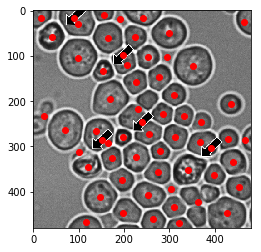

In [7]:
#入力画像上に検出した細胞をプロット
img_480 = Image.open("./img_480.png").convert("L")  
for i in range(cell_num):
    plt.plot(cell[i][0], cell[i][1], "ro")     
    
plt.imshow(np.asarray(img_480), cmap='gray')
print("細胞検出画像")

In [8]:
#各細胞の重心周りの画素輝度のばらつきの大きさで細胞を分類する

patch = 38 #細胞の周りのばらつきを考慮する範囲
TH_DIAP = 14040 #ばらつきのしきい値
#patch = 40
#TH_DIAP = 13800

flag = [0 for i in range(cell_num)]
for i in range(cell_num):
    sum = 0
    ave = 0
    disp = 0
    if (patch < cell[i][1] and cell[i][1] < (480-patch) and patch < cell[i][0] and cell[i][0] < (480-patch)):
        for y in range(int(cell[i][1]-patch) , int(cell[i][1]+patch)):
            for x in range(int(cell[i][0]-patch) , int(cell[i][0]+patch)):
                sum += imgdata[x+y*width]
        ave = sum/((patch*2)*(patch*2))
        for y in range(int(cell[i][1]-patch) , int(cell[i][1]+patch)):
            for x in range(int(cell[i][0]-patch) , int(cell[i][0]+patch)):
                disp += (abs(imgdata[x+y*width] - ave) * abs(imgdata[x+y*width] - ave))/((patch*2)*(patch*2))
        if disp > TH_DIAP:
            flag[i] = 1
            

分類後画像


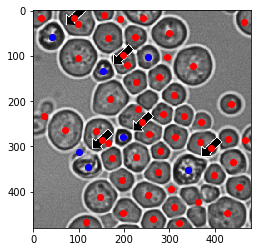

In [9]:
#入力画像上に検出した細胞をプロット
img_480 = Image.open("./img_480.png").convert("L")  
for i in range(cell_num):
    plt.plot(cell[i][0], cell[i][1], "ro")     
    
for i in range(cell_num):
    if flag[i] == 1:
        plt.plot(cell[i][0], cell[i][1], "bo")     
        
plt.imshow(np.asarray(img_480), cmap='gray')
print("分類後画像") 
plt.savefig("./img_output.png")